In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:

PATCH_DS = "/kaggle/input/camelyon-prepro-v4-patches"
SPLIT_DS = "/kaggle/input/split-wsi-level"
EMB_DS   = "/kaggle/input/patched-dinov2-embedded"

# Patches + CSV split
PATCH_DIR = os.path.join(PATCH_DS, "patches")
CSV_SPLIT = os.path.join(SPLIT_DS, "patches_metadata_with_split.csv")

# Embeddings ViT
FEATS_PATH = os.path.join(EMB_DS, "embeddings_dinov2", "features.npy")
INDEX_PATH = os.path.join(EMB_DS, "embeddings_dinov2", "index.csv")
DONE_PATH  = os.path.join(EMB_DS, "embeddings_dinov2", "done.npy")

print("PATCH_DIR :", PATCH_DIR)
print("CSV_SPLIT :", CSV_SPLIT)
print("FEATS_PATH:", FEATS_PATH)
print("INDEX_PATH:", INDEX_PATH)
print("DONE_PATH :", DONE_PATH)

# quick existence check
for p in [PATCH_DIR, CSV_SPLIT, FEATS_PATH, INDEX_PATH, DONE_PATH]:
    print(os.path.exists(p), p)


PATCH_DIR : /kaggle/input/camelyon-prepro-v4-patches/patches
CSV_SPLIT : /kaggle/input/split-wsi-level/patches_metadata_with_split.csv
FEATS_PATH: /kaggle/input/patched-dinov2-embedded/embeddings_dinov2/features.npy
INDEX_PATH: /kaggle/input/patched-dinov2-embedded/embeddings_dinov2/index.csv
DONE_PATH : /kaggle/input/patched-dinov2-embedded/embeddings_dinov2/done.npy
True /kaggle/input/camelyon-prepro-v4-patches/patches
True /kaggle/input/split-wsi-level/patches_metadata_with_split.csv
True /kaggle/input/patched-dinov2-embedded/embeddings_dinov2/features.npy
True /kaggle/input/patched-dinov2-embedded/embeddings_dinov2/index.csv
True /kaggle/input/patched-dinov2-embedded/embeddings_dinov2/done.npy


In [3]:
import os

OUT_DIR = "/kaggle/working/str_rw"
DONE_WSI_FILE = os.path.join(OUT_DIR, "done_wsi.txt")

# ⚠️ WARNING: force regeneration
if os.path.exists(DONE_WSI_FILE):
    os.remove(DONE_WSI_FILE)
    print("Removed checkpoint:", DONE_WSI_FILE)

In [4]:
index_df = pd.read_csv(INDEX_PATH)
done = np.load(DONE_PATH)

print("Index rows:", len(index_df))
print("Done ratio:", done.mean())

assert done.mean() > 0.99, "Embeddings incomplets: relancer Notebook 02."


Index rows: 16800
Done ratio: 1.0


In [5]:
# lire EMBED_DIM depuis une ligne (float16)
# on déduit D depuis le fichier en le mappant après avoir lu run_config si dispo.
# Ici, on fait simple: charger 1 vecteur via memmap en devinant D par run_config (recommandé)

# Option simple (si tu connais D=768):
EMBED_DIM = 768

feats = np.memmap(FEATS_PATH, dtype=np.float16, mode="r", shape=(len(index_df), EMBED_DIM))
print("Features memmap shape:", feats.shape)


Features memmap shape: (16800, 768)


In [6]:
# On travaille sur train/val/test (même split que le CSV)
# index_df doit déjà contenir split ; sinon tu merges avec CSV_SPLIT

print(index_df["split"].value_counts())

wsi_groups = {}
for split in ["train", "val", "test"]:
    sub = index_df[index_df["split"] == split]
    wsi_groups[split] = {wsi: grp.index.to_numpy() for wsi, grp in sub.groupby("wsi_id")}

print("Nb WSI train:", len(wsi_groups["train"]))
print("Nb WSI val:", len(wsi_groups["val"]))
print("Nb WSI test:", len(wsi_groups["test"]))


split
train    11700
test      2700
val       2400
Name: count, dtype: int64
Nb WSI train: 39
Nb WSI val: 8
Nb WSI test: 9


In [7]:
from collections import defaultdict
import numpy as np

def build_grid_neighbors(indices, xs, ys, step=256, use_8=True, radius_steps=2,
                         knn_k=3, knn_max_dist_steps=3):
    """
    Graphe spatial = voisins grille (rayon 1..radius_steps) + ponts kNN spatiaux.
    - knn_k: nb de voisins ajoutés par noeud
    - knn_max_dist_steps: distance max d'un pont en multiples de step (ex: 3 => 768 px)
    """
    # mapping position -> index
    pos2idx = {}
    for idx, x, y in zip(indices, xs, ys):
        pos2idx[(int(x), int(y))] = int(idx)

    # offsets de grille
    base = [(1,0),(-1,0),(0,1),(0,-1)]
    if use_8:
        base += [(1,1),(1,-1),(-1,1),(-1,-1)]

    neighbors = defaultdict(set)  # set pour éviter doublons

    # 1) voisins grille
    for (x, y), idx in pos2idx.items():
        for r in range(1, radius_steps + 1):
            for dx, dy in base:
                p = (x + dx*r*step, y + dy*r*step)
                if p in pos2idx:
                    j = pos2idx[p]
                    neighbors[idx].add(j)
                    neighbors[j].add(idx)

    # 2) ponts kNN spatiaux (brute force O(N^2) mais N par WSI est petit => OK)
    pts = np.stack([xs.astype(np.float32), ys.astype(np.float32)], axis=1)
    idxs = np.asarray(indices, dtype=int)

    max_dist = float(knn_max_dist_steps * step)
    max_dist2 = max_dist * max_dist

    n = len(idxs)
    if n > 1 and knn_k > 0:
        for i in range(n):
            # distances au carré
            d2 = np.sum((pts - pts[i])**2, axis=1)
            d2[i] = np.inf

            # candidats dans le rayon max
            cand = np.where(d2 <= max_dist2)[0]
            if cand.size == 0:
                continue

            # prendre les knn_k plus proches
            if cand.size > knn_k:
                cand = cand[np.argpartition(d2[cand], knn_k)[:knn_k]]

            u = int(idxs[i])
            for j in cand:
                v = int(idxs[j])
                neighbors[u].add(v)
                neighbors[v].add(u)

    # convertir set -> list (compat avec le reste de ton code)
    neighbors = {k: list(v) for k, v in neighbors.items()}
    return neighbors


In [8]:
L_MIN = 10
L_MAX = 30
RW_PER_WSI = 50
GRID_STEP = 256
USE_8 = True

radius_steps = 2
knn_k = 5
knn_max_dist_steps = 4

RNG = np.random.default_rng(0)

OVERLAP_TAU = 0.45
MIN_START_DIST = 10
MAX_TRIES_PER_PATH = 50

# Hiérarchie STAR -> BRIDGE -> LOCAL
END_CAND_MULT = 10
MAX_ATTEMPTS_WSI = 600

BRIDGE_MAX_HOPS = 2
BRIDGE_DIST_STEPS = 4

LOCAL_WALK_PROB = 0.35


In [9]:
OUT_DIR = "/kaggle/working/str_rw"
os.makedirs(OUT_DIR, exist_ok=True)

PATHS_FILE = os.path.join(OUT_DIR, "rw_paths.npy")
META_FILE  = os.path.join(OUT_DIR, "rw_meta.csv")
DONE_WSI_FILE = os.path.join(OUT_DIR, "done_wsi.txt")

print("OUT_DIR:", OUT_DIR)


OUT_DIR: /kaggle/working/str_rw


In [10]:
from collections import defaultdict, deque
import numpy as np
from tqdm import tqdm


def jaccard(a, b):
    a = set(a); b = set(b)
    inter = len(a & b)
    uni = len(a | b)
    return inter / uni if uni > 0 else 0.0

def shortest_path_bfs(neighbors, src, dst, max_visits=200000):
    if src == dst:
        return [src]
    q = deque([src])
    parent = {src: None}
    visits = 0
    while q:
        u = q.popleft()
        visits += 1
        if visits > max_visits:
            break
        for v in neighbors.get(u, []):
            if v not in parent:
                parent[v] = u
                if v == dst:
                    path = [dst]
                    cur = dst
                    while parent[cur] is not None:
                        cur = parent[cur]
                        path.append(cur)
                    path.reverse()
                    return path
                q.append(v)
    return None

def resample_to_length(path, L):
    if path is None or len(path) == 0:
        return None
    if len(path) == L:
        return path
    if len(path) > L:
        idx = np.linspace(0, len(path)-1, L).round().astype(int)
        return [path[i] for i in idx]
    out = list(path)
    while len(out) < L:
        out.append(out[-1])
    return out


# --- Helpers locaux ---
def random_walk_local(neighbors, start_idx, L, rng):
    walk = [int(start_idx)]
    cur = int(start_idx)
    for _ in range(L - 1):
        nbrs = neighbors.get(cur, [])
        if len(nbrs) == 0:
            break
        cur = int(rng.choice(nbrs))
        walk.append(cur)
    return walk

def path_acceptable(path, accepted_paths, overlap_tau):
    if path is None or len(path) == 0:
        return False
    if len(accepted_paths) == 0:
        return True
    max_j = max(jaccard(path, p2) for p2 in accepted_paths)
    return max_j <= overlap_tau

def bridge_candidates_from_neighbors(neighbors, start, xs_map, ys_map, max_dist_px):
    """Retourne les voisins de start dont la distance spatiale <= max_dist_px."""
    cand = []
    x0, y0 = xs_map.get(start, None), ys_map.get(start, None)
    if x0 is None:
        return cand
    for v in neighbors.get(start, []):
        xv, yv = xs_map.get(v, None), ys_map.get(v, None)
        if xv is None:
            continue
        dx = float(xv - x0); dy = float(yv - y0)
        if dx*dx + dy*dy <= max_dist_px*max_dist_px:
            cand.append(int(v))
    return cand

def farthest_point_starts(indices, xs, ys, k, min_dist_steps=10, step=256, rng=None):
    """
    Sélectionne k indices (dans 'indices') en maximisant l'éloignement spatial (farthest point sampling).
    - min_dist_steps: distance minimale souhaitée en multiples de 'step' (ex: 10 -> 2560px)
    """
    if rng is None:
        rng = np.random.default_rng()

    indices = np.asarray(indices, dtype=int)
    xs = np.asarray(xs, dtype=np.float32)
    ys = np.asarray(ys, dtype=np.float32)

    n = len(indices)
    if n == 0:
        return []
    if k <= 1:
        return [int(indices[int(rng.integers(n))])]

    pts = np.stack([xs, ys], axis=1)  # (n,2)

    # 1er point aléatoire
    first = int(rng.integers(n))
    chosen_idx = [first]

    # distance min en pixels
    min_dist = float(min_dist_steps * step)

    for _ in range(1, k):
        chosen_pts = pts[chosen_idx]  # (m,2)
        # distance au point choisi le plus proche
        d = np.min(np.linalg.norm(pts[:, None, :] - chosen_pts[None, :, :], axis=2), axis=1)  # (n,)

        # candidats respectant min_dist
        cand = np.where(d >= min_dist)[0]
        if cand.size == 0:
            nxt = int(np.argmax(d))
        else:
            nxt = int(cand[np.argmax(d[cand])])

        chosen_idx.append(nxt)

    return [int(indices[i]) for i in chosen_idx]


In [11]:
all_rows = []
all_paths = []

done_wsi = set()
if os.path.exists(DONE_WSI_FILE):
    with open(DONE_WSI_FILE, "r") as f:
        done_wsi = set([line.strip() for line in f if line.strip()])
    print("Checkpoint WSI:", len(done_wsi))

for split in ["train", "val", "test"]:
    for wsi_id, idxs in tqdm(wsi_groups[split].items(), desc=f"RW {split}"):

        key = f"{split}/{wsi_id}"
        if key in done_wsi:
            continue

        xs = index_df.loc[idxs, "x"].to_numpy()
        ys = index_df.loc[idxs, "y"].to_numpy()

        # label WSI (sûr) : tous les patchs d'une WSI ont le même label chez toi,
        # mais on prend max pour être robuste
        label_wsi = int(index_df.loc[idxs, "label"].max())

        # (1) Graphe enrichi : grille + kNN bridges
        neighbors = build_grid_neighbors(
            indices=idxs, xs=xs, ys=ys,
            step=GRID_STEP,
            use_8=USE_8,
            radius_steps=radius_steps,
            knn_k=knn_k,
            knn_max_dist_steps=knn_max_dist_steps
        )
        if len(neighbors) == 0:
            continue

        # noeuds "utilisables" = ceux qui ont au moins 1 voisin
        idxs_conn = np.array(list(neighbors.keys()), dtype=int)
        if len(idxs_conn) < 5:
            continue

        xs_conn = index_df.loc[idxs_conn, "x"].to_numpy()
        ys_conn = index_df.loc[idxs_conn, "y"].to_numpy()

        # maps rapides idx -> x,y (sur noeuds connectés)
        xs_map = {int(i): int(x) for i, x in zip(idxs_conn, xs_conn)}
        ys_map = {int(i): int(y) for i, y in zip(idxs_conn, ys_conn)}

        # (2) Hub connecté (max degré)
        hub = int(max(neighbors.keys(), key=lambda n: len(neighbors[n])))

        # (3) Candidats endpoints (beaucoup plus que 20)
        cand_k = RW_PER_WSI * END_CAND_MULT
        end_cands = farthest_point_starts(
            idxs_conn, xs_conn, ys_conn,
            k=cand_k,
            min_dist_steps=max(2, MIN_START_DIST // 2),
            step=GRID_STEP,
            rng=RNG
        )

        accepted_paths = []
        attempts = 0
        i = 0

        # ------------------------------
        # MODE A/B : STAR puis BRIDGE
        # ------------------------------
        while len(accepted_paths) < RW_PER_WSI and attempts < MAX_ATTEMPTS_WSI and i < len(end_cands) - 1:
            start = int(end_cands[i])
            end   = int(end_cands[i + 1])
            i += 1
            attempts += 1

            p1 = shortest_path_bfs(neighbors, start, hub)
            p2 = shortest_path_bfs(neighbors, hub, end)

            mode = None
            bridges_used = 0
            path = None

            if p1 is not None and p2 is not None:
                path = p1 + p2[1:]
                mode = "star"
            else:
                # ---- BRIDGE fallback ----
                max_dist_px = BRIDGE_DIST_STEPS * GRID_STEP
                cur_start = start

                ok = False
                for hop in range(BRIDGE_MAX_HOPS):
                    cands = bridge_candidates_from_neighbors(neighbors, cur_start, xs_map, ys_map, max_dist_px)
                    if len(cands) == 0:
                        break

                    RNG.shuffle(cands)
                    cands = cands[: min(8, len(cands))]   # un peu plus large

                    for b in cands:
                        p1b = shortest_path_bfs(neighbors, b, hub)
                        p2b = shortest_path_bfs(neighbors, hub, end)
                        if p1b is not None and p2b is not None:
                            path = [cur_start, b] + p1b[1:] + p2b[1:]
                            mode = "bridge"
                            bridges_used = hop + 1
                            ok = True
                            break
                    if ok:
                        break

            if path is None:
                continue

            # Longueur variable
            if len(path) < L_MIN:
                continue
            if len(path) > L_MAX:
                path = resample_to_length(path, L_MAX)

            if not path_acceptable(path, accepted_paths, OVERLAP_TAU):
                continue

            accepted_paths.append(path)
            all_paths.append(path)
            all_rows.append({
                "split": split,
                "wsi_id": wsi_id,
                "path_id": len(all_paths) - 1,
                "path_len": len(path),
                "label": label_wsi,
                "start_idx": start,
                "hub_idx": hub,
                "end_idx": end,
                "mode": mode,
                "bridges_used": bridges_used
            })

        # ------------------------------
        # MODE C : LOCAL fallback (remplir jusqu'à 20)
        # ------------------------------
        tries = 0
        while len(accepted_paths) < RW_PER_WSI and tries < MAX_ATTEMPTS_WSI:
            tries += 1
            start = int(RNG.choice(idxs_conn))
            L = int(RNG.integers(L_MIN, L_MAX + 1))

            path = random_walk_local(neighbors, start, L, RNG)
            if len(path) < L_MIN:
                continue

            if not path_acceptable(path, accepted_paths, OVERLAP_TAU):
                continue

            accepted_paths.append(path)
            all_paths.append(path)
            all_rows.append({
                "split": split,
                "wsi_id": wsi_id,
                "path_id": len(all_paths) - 1,
                "path_len": len(path),
                "label": label_wsi,
                "start_idx": start,
                "hub_idx": hub,
                "end_idx": start,
                "mode": "local",
                "bridges_used": 0
            })

        # Debug rare
        if RNG.random() < 0.03:
            print(split, wsi_id,
                  "patches=", len(idxs),
                  "nodes_in_graph=", len(neighbors),
                  "accepted=", len(accepted_paths),
                  "attempts=", attempts)

# Résumé
meta_df = pd.DataFrame(all_rows)
print("Total paths:", len(all_paths))
print(meta_df.groupby("split")["path_id"].count())
print("\nPaths per WSI (describe):")
print(meta_df.groupby(["split","wsi_id"]).size().describe())

print("\nModes distribution:")
print(meta_df["mode"].value_counts())
print("\nMode per split:")
print(meta_df.groupby(["split","mode"]).size())


RW train:  38%|███▊      | 15/39 [00:27<00:44,  1.87s/it]

train normal_146 patches= 300 nodes_in_graph= 298 accepted= 50 attempts= 499


RW test:  89%|████████▉ | 8/9 [00:14<00:01,  1.81s/it]

test tumor_097 patches= 300 nodes_in_graph= 299 accepted= 50 attempts= 499


RW test: 100%|██████████| 9/9 [00:16<00:00,  1.82s/it]

Total paths: 2800
split
test      450
train    1950
val       400
Name: path_id, dtype: int64

Paths per WSI (describe):
count    56.0
mean     50.0
std       0.0
min      50.0
25%      50.0
50%      50.0
75%      50.0
max      50.0
dtype: float64

Modes distribution:
mode
star     1609
local    1191
Name: count, dtype: int64

Mode per split:
split  mode 
test   local     215
       star      235
train  local     708
       star     1242
val    local     268
       star      132
dtype: int64


In [12]:
print("Total paths:", len(all_paths))
meta_df = pd.DataFrame(all_rows)

print(meta_df.groupby("split")["path_id"].count())
print("Min path_len:", meta_df["path_len"].min())
print("Max path_len:", meta_df["path_len"].max())
print("Mean path_len:", meta_df["path_len"].mean())


Total paths: 2800
split
test      450
train    1950
val       400
Name: path_id, dtype: int64
Min path_len: 10
Max path_len: 30
Mean path_len: 16.9


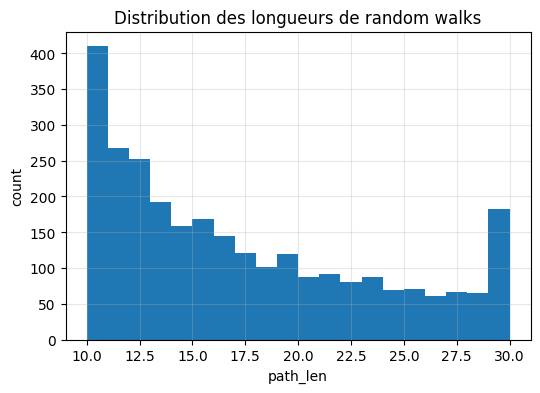

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(meta_df["path_len"], bins=20)
plt.title("Distribution des longueurs de random walks")
plt.xlabel("path_len")
plt.ylabel("count")
plt.grid(alpha=0.3)
plt.show()


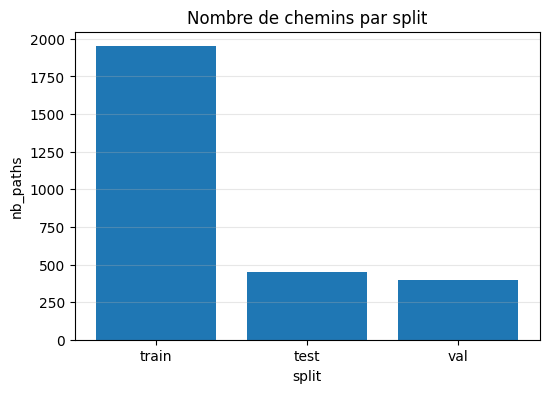

In [14]:
counts = meta_df["split"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values)
plt.title("Nombre de chemins par split")
plt.xlabel("split")
plt.ylabel("nb_paths")
plt.grid(axis="y", alpha=0.3)
plt.show()


In [15]:
import os

OUT_DIR = "/kaggle/working/str_rw"
print("Files in OUT_DIR:", os.listdir(OUT_DIR))

for f in ["rw_paths.npy", "rw_meta.csv", "done_wsi.txt"]:
    p = os.path.join(OUT_DIR, f)
    print(f, "exists?", os.path.exists(p), "size(MB)=", (os.path.getsize(p)/1e6 if os.path.exists(p) else None))


Files in OUT_DIR: []
rw_paths.npy exists? False size(MB)= None
rw_meta.csv exists? False size(MB)= None
done_wsi.txt exists? False size(MB)= None


In [16]:
import os
import numpy as np
import pandas as pd

OUT_DIR = "/kaggle/working/str_rw"
os.makedirs(OUT_DIR, exist_ok=True)

PATHS_FILE = os.path.join(OUT_DIR, "rw_paths.npy")
META_FILE  = os.path.join(OUT_DIR, "rw_meta.csv")

# Si tu n'as pas meta_df, le reconstruire
if "meta_df" not in globals():
    meta_df = pd.DataFrame(all_rows)

print("About to save:")
print(" - paths:", len(all_paths))
print(" - meta :", len(meta_df))

print(meta_df["path_len"].describe())
print(meta_df.groupby("split")["path_len"].describe())


# Sauver les chemins (liste variable) -> npy object (important: allow_pickle)
np.save(PATHS_FILE, np.array(all_paths, dtype=object))

# Sauver meta
meta_df.to_csv(META_FILE, index=False)

print("Saved:", PATHS_FILE)
print("Saved:", META_FILE)

print("\nCheck OUT_DIR content:")
print(os.listdir(OUT_DIR))

print("\nSizes (MB):")
for f in ["rw_paths.npy", "rw_meta.csv", "done_wsi.txt"]:
    p = os.path.join(OUT_DIR, f)
    print(f, "exists?", os.path.exists(p),
          "size(MB)=", (os.path.getsize(p)/1e6 if os.path.exists(p) else None))


About to save:
 - paths: 2800
 - meta : 2800
count    2800.000000
mean       16.900000
std         6.148165
min        10.000000
25%        12.000000
50%        15.000000
75%        21.000000
max        30.000000
Name: path_len, dtype: float64
        count       mean       std   min   25%   50%   75%   max
split                                                           
test    450.0  16.628889  6.011686  10.0  11.0  15.0  21.0  30.0
train  1950.0  16.830769  6.122160  10.0  12.0  15.0  21.0  30.0
val     400.0  17.542500  6.394954  10.0  12.0  16.0  23.0  30.0
Saved: /kaggle/working/str_rw/rw_paths.npy
Saved: /kaggle/working/str_rw/rw_meta.csv

Check OUT_DIR content:
['rw_paths.npy', 'rw_meta.csv']

Sizes (MB):
rw_paths.npy exists? True size(MB)= 0.163227
rw_meta.csv exists? True size(MB)= 0.137327
done_wsi.txt exists? False size(MB)= None


rw_meta: (2800, 10) rw_paths: 2800 index_df: (16800, 6)
Example WSI: tumor_078
Saved: /kaggle/working/fig_rw_trajectories.png


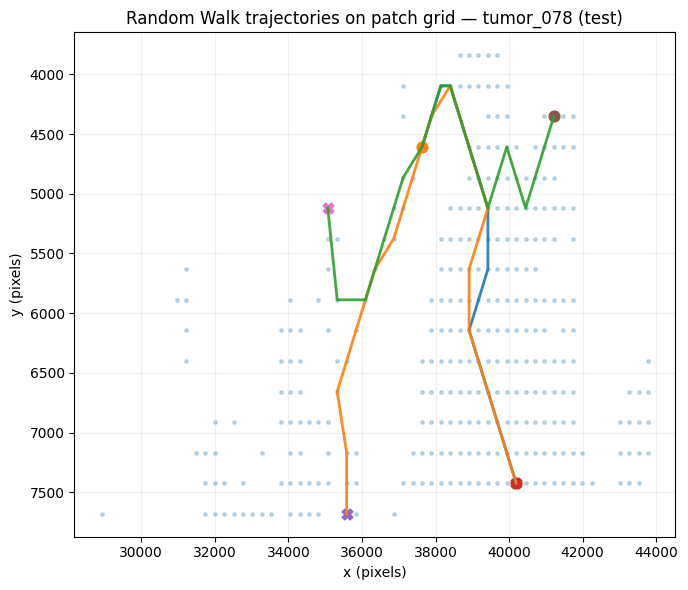

In [17]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# === Paths (adapte si besoin) ===
RW_DIR   = "/kaggle/working/str_rw"   # dataset RW publié
EMB_DS   = "/kaggle/input/patched-dinov2-embedded"     # embeddings DINOv2
INDEX_CSV = os.path.join(EMB_DS, "embeddings_dinov2", "index.csv")  # (oui le dossier s'appelle embeddings_vit chez toi)

RW_META  = os.path.join(RW_DIR, "rw_meta.csv")
RW_PATHS = os.path.join(RW_DIR, "rw_paths.npy")

rw_meta  = pd.read_csv(RW_META)
rw_paths = np.load(RW_PATHS, allow_pickle=True)
index_df = pd.read_csv(INDEX_CSV)

print("rw_meta:", rw_meta.shape, "rw_paths:", len(rw_paths), "index_df:", index_df.shape)

# === Choisir une WSI à illustrer (ex: une tumor du split test) ===
ex = rw_meta[(rw_meta["split"]=="test") & (rw_meta["label"]==1)].iloc[0]
wsi_id = ex["wsi_id"]
print("Example WSI:", wsi_id)

# sous-table patchs de cette WSI
sub_idx = index_df[index_df["wsi_id"]==wsi_id].copy()

# map index global -> (x,y)
# ATTENTION: dans ton pipeline, le path contient des indices globaux "i" qui correspondent à index_df rows.
# Donc on accède directement par loc sur index_df.
# On va juste utiliser index_df.loc[path_indices, ["x","y"]]

# === sélection de 3 trajectoires sur cette WSI ===
paths_ids = rw_meta[(rw_meta["wsi_id"]==wsi_id) & (rw_meta["split"]==ex["split"])].head(3)["path_id"].tolist()

plt.figure(figsize=(7,6))

# 1) fond : nuage de patchs (x,y)
plt.scatter(sub_idx["x"], sub_idx["y"], s=6, alpha=0.25)

# 2) overlay : chaque trajectoire
for j, pid in enumerate(paths_ids):
    p = rw_paths[int(pid)]              # liste d'indices globaux
    coords = index_df.loc[p, ["x","y"]].to_numpy()
    plt.plot(coords[:,0], coords[:,1], linewidth=2, alpha=0.9)
    plt.scatter(coords[0,0], coords[0,1], s=60, marker="o")   # start
    plt.scatter(coords[-1,0], coords[-1,1], s=60, marker="X") # end

plt.gca().invert_yaxis()
plt.title(f"Random Walk trajectories on patch grid — {wsi_id} ({ex['split']})")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.grid(alpha=0.2)
plt.tight_layout()

OUT = "/kaggle/working/fig_rw_trajectories.png"
plt.savefig(OUT, dpi=200)
print("Saved:", OUT)

plt.show()


In [18]:
import numpy as np
import pandas as pd
import os

vit_feat_path  = "/kaggle/input/patched-vit-embedded/embeddings_vit/features.npy"
vit_index_path = "/kaggle/input/patched-vit-embedded/embeddings_vit/index.csv"

dino_feat_path  = "/kaggle/input/patched-dinov2-embedded/embeddings_dinov2/features.npy"
dino_index_path = "/kaggle/input/patched-dinov2-embedded/embeddings_dinov2/index.csv"

D = 768

def load_memmap_float16(feat_path, index_path, D):
    idx = pd.read_csv(index_path)
    N = len(idx)

    actual_bytes = os.path.getsize(feat_path)
    expected_bytes = N * D * 2  # float16

    print("\n==", feat_path)
    print("N:", N, "D:", D)
    print("file bytes:", actual_bytes, "| expected float16:", expected_bytes)
    assert actual_bytes == expected_bytes, "Taille incompatible avec float16 (N×D×2)."

    feats = np.memmap(feat_path, dtype=np.float16, mode="r", shape=(N, D))
    print("loaded:", feats.shape, feats.dtype)
    return feats, idx

vit_feats, vit_idx = load_memmap_float16(vit_feat_path, vit_index_path, D)
dino_feats, dino_idx = load_memmap_float16(dino_feat_path, dino_index_path, D)

print("\nViT D =", vit_feats.shape[1])
print("DINO D =", dino_feats.shape[1])



== /kaggle/input/patched-vit-embedded/embeddings_vit/features.npy
N: 16800 D: 768
file bytes: 25804800 | expected float16: 25804800
loaded: (16800, 768) float16

== /kaggle/input/patched-dinov2-embedded/embeddings_dinov2/features.npy
N: 16800 D: 768
file bytes: 25804800 | expected float16: 25804800
loaded: (16800, 768) float16

ViT D = 768
DINO D = 768


In [19]:
import pandas as pd

vit_index = pd.read_csv("/kaggle/input/patched-vit-embedded/embeddings_vit/index.csv")
dino_index = pd.read_csv("/kaggle/input/patched-dinov2-embedded/embeddings_dinov2/index.csv")

print("ViT index rows:", len(vit_index))
print("DINO index rows:", len(dino_index))


ViT index rows: 16800
DINO index rows: 16800


In [20]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# === A adapter si besoin ===
PATCH_DS = "/kaggle/input/camelyon-prepro-v4-patches"  # dataset qui contient /patches/*.png
PATCH_DIR = os.path.join(PATCH_DS, "patches")

# Si ton index_df/rw_meta/rw_paths sont déjà en mémoire, saute la partie load.
# Sinon adapte les chemins :
# index_df = pd.read_csv(INDEX_PATH)
# rw_meta  = pd.read_csv(RW_META)
# rw_paths = np.load(RW_PATHS, allow_pickle=True)

def resolve_patch_path(p):
    """index_df['patch_path'] peut être 'patches/xxx.png' ou juste 'xxx.png'."""
    p = str(p)
    if os.path.isabs(p) and os.path.exists(p):
        return p
    # cas courant: "patches/....png"
    cand1 = os.path.join(PATCH_DS, p)
    if os.path.exists(cand1):
        return cand1
    # cas: juste nom de fichier
    cand2 = os.path.join(PATCH_DIR, os.path.basename(p))
    if os.path.exists(cand2):
        return cand2
    return None

def get_path_indices_for_wsi(wsi_id, n_show=5, prefer_mode=None, seed=0):
    """Retourne une liste de path_id pour une WSI (option: mode='star' ou 'local' si présent)."""
    sub = rw_meta[rw_meta["wsi_id"] == wsi_id].copy()
    if prefer_mode is not None and "mode" in sub.columns:
        sub2 = sub[sub["mode"] == prefer_mode]
        if len(sub2) > 0:
            sub = sub2
    if len(sub) == 0:
        return []
    rng = np.random.default_rng(seed)
    pick = sub.sample(n=min(n_show, len(sub)), random_state=int(rng.integers(1_000_000)))
    return pick["path_id"].astype(int).tolist()


WSI: tumor_078 | nb_patches: 300 | path_ids: [2581, 2553, 2586, 2561, 2563]


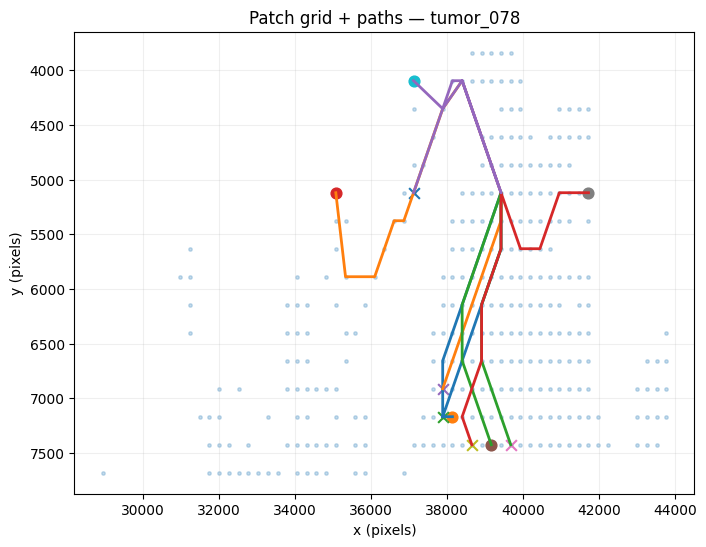

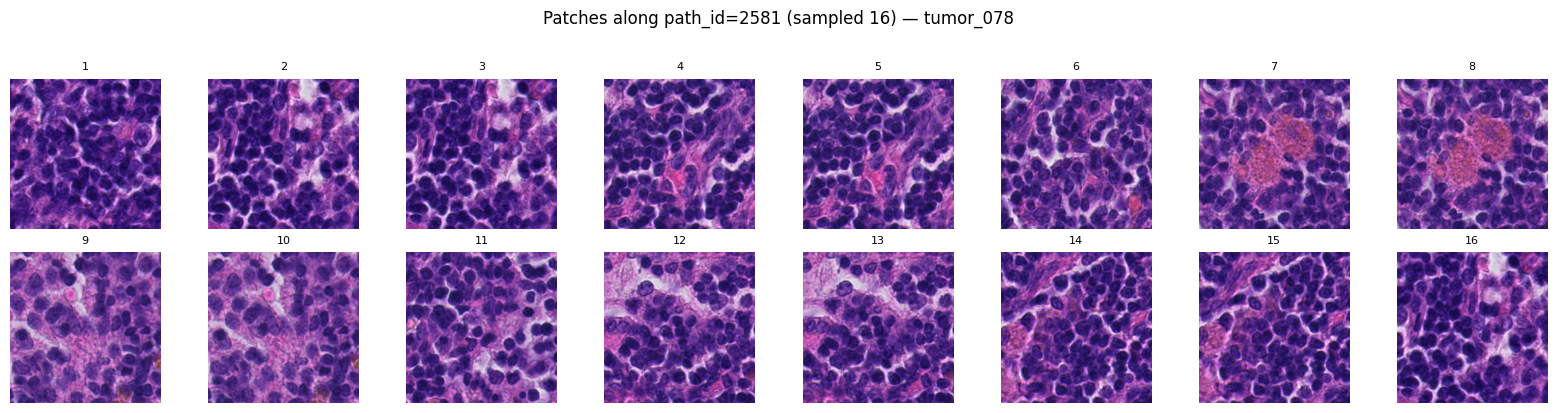

In [21]:
import math

WSI_ID = "tumor_078"  # <-- mets la WSI que tu veux
N_PATHS_OVERLAY = 5   # nb de chemins à tracer sur la carte
MODE_PREF = None      # "star" ou "local" si tu veux forcer un type

# --- 1) Carte des patchs + chemins ---
idxs = index_df[index_df["wsi_id"] == WSI_ID].index.to_numpy()
xs = index_df.loc[idxs, "x"].to_numpy()
ys = index_df.loc[idxs, "y"].to_numpy()

path_ids = get_path_indices_for_wsi(WSI_ID, n_show=N_PATHS_OVERLAY, prefer_mode=MODE_PREF, seed=0)
print("WSI:", WSI_ID, "| nb_patches:", len(idxs), "| path_ids:", path_ids)

plt.figure(figsize=(8,6))
plt.scatter(xs, ys, s=6, alpha=0.25)
plt.gca().invert_yaxis()
plt.title(f"Patch grid + paths — {WSI_ID}")
plt.xlabel("x (pixels)"); plt.ylabel("y (pixels)")
plt.grid(alpha=0.2)

for pid in path_ids:
    path = rw_paths[pid]
    # coords du chemin
    px = index_df.loc[path, "x"].to_numpy()
    py = index_df.loc[path, "y"].to_numpy()
    plt.plot(px, py, linewidth=2)
    # start / end
    plt.scatter([px[0]], [py[0]], s=60, marker="o")
    plt.scatter([px[-1]], [py[-1]], s=60, marker="x")

plt.show()

# --- 2) Montage de patchs le long d'un chemin (le 1er) ---
if len(path_ids) > 0:
    pid = path_ids[0]
    path = rw_paths[pid]
    # on échantillonne 16 patchs le long du chemin
    n_tiles = 16
    take = np.linspace(0, len(path)-1, n_tiles).round().astype(int)
    take = [int(path[i]) for i in take]

    imgs = []
    for j in take:
        p = resolve_patch_path(index_df.loc[j, "patch_path"])
        if p is None:
            imgs.append(None)
            continue
        imgs.append(Image.open(p).convert("RGB"))

    cols = 8
    rows = math.ceil(n_tiles / cols)
    plt.figure(figsize=(2*cols, 2*rows))
    for i, im in enumerate(imgs):
        ax = plt.subplot(rows, cols, i+1)
        ax.axis("off")
        if im is None:
            ax.set_title("missing", fontsize=8)
            continue
        ax.imshow(im)
        ax.set_title(f"{i+1}", fontsize=8)
    plt.suptitle(f"Patches along path_id={pid} (sampled {n_tiles}) — {WSI_ID}", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Aucun chemin trouvé pour cette WSI (vérifie WSI_ID / rw_meta).")
